# Face Inversion Effect in CNNs

This notebook is structured as follows:

1. Imports
2. Loading the data
3. Creating the model and optimizer
4. Training
5. Plotting and saving the results

See the README file in the root of the repository for more information.

## Imports

In [2]:
import os
import time
import copy

import operator
from collections import Counter
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('darkgrid')

import torch
import torch.nn as nn
import torchvision

from tqdm.auto import tqdm
import attach

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.0
Torchvision Version:  0.9.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# For PyTorch’s SqueezeNet, this is 224; change if using a different model.
input_size = 224

## Loading the dataset

In [5]:
# Download the CelebA dataset.

def CelebA(transform=None, target_transform=None, download=False):
    return torchvision.datasets.CelebA(
        root='data',
        split='all',
        target_type='identity',
        transform=transform,
        target_transform=target_transform,
        download=download,
    )

dataset = CelebA(download=True)
dataset

Files already downloaded and verified


Dataset CelebA
    Number of datapoints: 202599
    Root location: data
    Target type: ['identity']
    Split: all

In [6]:
# “Identity” is an integer assigned to each celebrity. This is the class to be predicted.
# Multiple shots of same celebrity will have the same identity.

# Identity of each sample.
identity = pd.Series(dataset.identity.squeeze())

# How many times each identity appears.
samples_per_class = identity.value_counts()

# How many classes are of a certain size.
classes_per_size = identity.value_counts().value_counts()

num_classes_possible = len(samples_per_class)
print(f"The CelebA dataset has {len(dataset.identity)} samples across {num_classes_possible} classes.")

In [20]:
print("First column is size of class; second column is how many classes have that size.")
classes_per_size.sort_index(ascending=False)

First column is size of class; second column is how many classes have that size.


35       3
34       2
32       3
31       9
30    2343
29     493
28     216
27     125
26     106
25     361
24     290
23     369
22     419
21     565
20    1044
19     288
18     217
17     173
16     219
15     172
14     210
13     176
12     165
11     199
10     202
9      187
8      176
7      183
6      207
5      221
4      221
3      245
2      324
1       44
dtype: int64

In [9]:
# Some classes have barely any samples!
# Let’s filter by classes that have 30 samples exactly, to ensure we have enough per class.
classes_with_right_size = list(samples_per_class[samples_per_class == 30].index)

In [10]:
# To speed up training, we’ll only work with 20 classes.
NUM_CLASSES = 20

In [21]:
# Choose the classes to work with.

chosen_classes = classes_with_right_size[:NUM_CLASSES]

# Facilitate renumbering of chosen classes as 0, 1, 2, 3 etc. rather than 7755, 7883, 8011.
# class_to_class_idx = {
#     cls: i
#     for i, cls in enumerate(chosen_classes)
# }

print(f"We selected {NUM_CLASSES} of the {len(classes_with_right_size)} classes with size {30} each.")

We selected 20 of the 2343 classes with size 30 each.


In [22]:
# Split into training, validation, test.
# We don’t really use the test dataset here; hence why it’s small and left alone.

idx_for_class = {
    
    cls:
        list(identity[identity == cls].index)
    
    for cls in chosen_classes
}

flatten = lambda arr: np.array(arr).flatten()

train_idx, val_idx, test_idx = map(flatten, zip(*[
    (idx[:20], idx[20:29], idx[29:])
    for idx in idx_for_class.values()
]))

print(f"We have {len(train_idx)} training examples, {len(val_idx)} for validation, and {len(test_idx)} for testing.")

We have 400 training examples, 180 for validation, and 20 for testing.


In [29]:
# Applying transforms to the data.
# - Data augmentation and normalization for training.
# - Just normalization for validation.
# - Normalisation and vertical flipping to evaluate accuracy on inverted images.

transforms = torchvision.transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

inv_eval_transform = transforms.Compose([
    transforms.RandomVerticalFlip(1),  # 1 means always flip
    eval_transform
])

In [17]:
# TODO: Make model have only NUM_CLASSES outputs, rather than num_classes_possible. Would help reduce parameters vastly;
#
# @torchvision.transforms.Lambda
# def target_transform_(label):
#     print(label.item(), class_to_class_idx.get(label.item()))
#     return torch.Tensor([class_to_class_idx.get(label.item(), 0)])

target_transform = None

In [30]:
# Subset the original dataset using the train/val/test indices provided.

make_subset = lambda transform, idx: torch.utils.data.Subset(
    CelebA(transform=transform, target_transform=target_transform),
    idx)

train_subset = make_subset(train_transform, train_idx)
val_subset   = make_subset(eval_transform,  val_idx)
test_subset  = make_subset(eval_transform,  test_idx)

inv_subset   = make_subset(inv_eval_transform,  val_idx)

In [31]:
# Create batch-based data loaders.

BATCH_SIZE = 8

make_dataloader = (lambda subset:
    torch.utils.data.DataLoader(
        subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4))

train_dataloader = make_dataloader(train_subset)
val_dataloader   = make_dataloader(val_subset)
test_dataloader  = make_dataloader(test_subset)
inv_dataloader   = make_dataloader(inv_subset)

## Creating the model and optimiser

The model is SqueezeNet 1.0 architecture, selected due to its small parameter size. The initial weights come from pre-training on ImageNet. The last classifier layer is changed to have as many outputs as there are classes. This output will then get softmaxed and compared to the true label using PyTorch’s CrossEntropyLoss criterion.

Note in particular the `FEATURE_EXTRACT` flag. When False, the entire model is fine-tuned; when True, only the last classifier layer’s weights are updated. The latter is achieved by setting `requires_grad` to False for all the model weights. Then the classifier layer is replaced, which has `requires_grad` set to True by default.

We use SGD for optimisation. Adam didn’t work as well, despite playing around with different learning rates.

In [33]:
FEATURE_EXTRACT = False

In [34]:
model = torchvision.models.squeezenet1_0(pretrained=True)

if FEATURE_EXTRACT:
    for param in model.parameters():
        param.requires_grad = False

# Change final layer to match number of classes being predicted.
# These will have requires_grad=True by default.
model.classifier[1] = nn.Conv2d(512, num_classes_possible, kernel_size=(1,1), stride=(1,1))
model.num_classes = num_classes_possible

model = model.to(device)

In [35]:
params_to_optimize = {}
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_optimize[name] = param
    
print("Params to train:")
for name, param in params_to_optimize.items():
    print(" "*2, name)

optimizer = torch.optim.SGD(params_to_optimize.values(), lr=0.001, momentum=0.9)

Params to train:
   features.0.weight
   features.0.bias
   features.3.squeeze.weight
   features.3.squeeze.bias
   features.3.expand1x1.weight
   features.3.expand1x1.bias
   features.3.expand3x3.weight
   features.3.expand3x3.bias
   features.4.squeeze.weight
   features.4.squeeze.bias
   features.4.expand1x1.weight
   features.4.expand1x1.bias
   features.4.expand3x3.weight
   features.4.expand3x3.bias
   features.5.squeeze.weight
   features.5.squeeze.bias
   features.5.expand1x1.weight
   features.5.expand1x1.bias
   features.5.expand3x3.weight
   features.5.expand3x3.bias
   features.7.squeeze.weight
   features.7.squeeze.bias
   features.7.expand1x1.weight
   features.7.expand1x1.bias
   features.7.expand3x3.weight
   features.7.expand3x3.bias
   features.8.squeeze.weight
   features.8.squeeze.bias
   features.8.expand1x1.weight
   features.8.expand1x1.bias
   features.8.expand3x3.weight
   features.8.expand3x3.bias
   features.9.squeeze.weight
   features.9.squeeze.bias
   feat

## Training the model

In [25]:
# The training state is updated after each epoch of training and persisted to disk.

training_state = {
    
    'epochs_done': 0,
    
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'inv_loss': [],
    'inv_acc': [],
    
    # Commented because saving all model weights consumed way too much memory.
    # 'model_weights': [],
    
    'best_acc': 0,
    'best_model_weights': None,

}

def training_state_filepath(epoch=None):
    if epoch is None:
        epoch = training_state['epochs_done']
    return f'''saved_state/{experiment_name}_{"featureextract" if FEATURE_EXTRACT else "finetune"}_epoch{epoch}.pt'''

def load_training_state(epoch):
    global training_state, model
    training_state = torch.load(training_state_filepath(epoch))
    model.load_state_dict(training_state['best_model_weights'])

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
def weights(model):
    """ Get copy of model state """
    # model.state_dict() encompasses more than model.parameters().
    return copy.deepcopy(model.state_dict())

In [21]:
def train_epoch():
    
    # Mintaining running stats, updated for each batch.
    running_loss = 0
    running_corrects = 0
    
    # The train phase trains, the validation phase just evaluates, and
    #  the inv phase is the same, but evaluating on inverted images.
    for phase in ['train', 'valid', 'inv']:

        # Changes behaviour of special features like Dropout and BatchNorm.
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        # Select dataloader.
        if phase == 'train':
            dataloader = train_dataloader
        elif phase == 'valid':
            dataloader = val_dataloader
        elif phase == 'inv': 
            dataloader = inv_dataloader
        else:
            assert False

        # Update the running stats.
        running_loss = 0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forwards phase: enable gradient tracking only if training.
            with torch.set_grad_enabled(phase == 'train'):

                # Notes:
                # - `outputs` contains non-softmaxed output for each class for each sample.
                # - CrossEntropyLoss takes care of softmaxing and comparing to the true class.
                # - torch.max returns max and index of max; we want the latter, i.e. the maximising class.
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, axis=1)                

                # Backwards phase: optimize only if in training.
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Update running stats for this batch.
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        # Notes:
        # - Need to convert `running_corrects` into a double datatype, to support float division. 

        # Compute final epoch stats.
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        
        print('{} loss: {:.4f} acc: {:.2f}%'.format(phase, epoch_loss, epoch_acc*100))
        
        # Update the training state.
        global training_state

        if phase == 'train':
            
            training_state['epochs_done'] += 1
            
            training_state['train_loss'].append(epoch_loss)
            training_state['train_acc'].append(epoch_acc)
            
            # training_state['model_weights'].append(weights(model))
        
        elif phase == 'valid':
            
            training_state['val_loss'].append(epoch_loss)
            training_state['val_acc'].append(epoch_acc)
            
            if epoch_acc > training_state['best_acc']:
                training_state['best_acc'] = epoch_acc
                training_state['best_model_weights'] = weights(model)
            
           
        elif phase == 'inv':
            
            training_state['inv_loss'].append(epoch_loss)
            training_state['inv_acc'].append(epoch_acc)
            
            torch.save(training_state, training_state_filepath())

In [22]:
def train_more(num_epochs):
    
    # Restore model to last trained state.
    # if training_state['epochs_done'] > 0:
    #     model.load_state_dict(training_state['last_model_weights'][-1])
    
    for _ in range(num_epochs):
    
        epoch = training_state['epochs_done']
        
        print(f'Epoch {epoch+1}')
        print('-' * 10)
    
        train_epoch()

        print()
        
    # Put model in best-so-far state.
    # model.load_state_dict(training_state['best_model_weights'])

In [23]:
# Notes before training:
#
# - Make sure to reset `training_state`.
# - Make sure to reset model pre-trained weights.
# - Make sure to set experiment name correctly.

In [24]:
experiment_name = '8_sgd_100class'

In [30]:
train_more(10)

Epoch 1
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 6.4866 acc: 1.10%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 4.8235 acc: 2.11%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.8674 acc: 1.67%

Epoch 2
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 4.7309 acc: 3.20%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 4.3778 acc: 3.44%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.4793 acc: 3.89%

Epoch 3
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 4.3539 acc: 4.50%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 4.0467 acc: 7.44%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.2878 acc: 5.44%

Epoch 4
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 4.0389 acc: 8.45%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 3.9172 acc: 9.22%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.2537 acc: 6.44%

Epoch 5
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 3.8018 acc: 11.50%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 3.6369 acc: 13.33%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.0238 acc: 8.33%

Epoch 6
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 3.6299 acc: 14.45%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 3.5490 acc: 17.33%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.2864 acc: 9.67%

Epoch 7
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 3.4156 acc: 19.40%


  0%|          | 0/113 [00:03<?, ?it/s]

valid loss: 3.1755 acc: 22.89%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 3.8044 acc: 12.78%

Epoch 8
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 3.1890 acc: 21.65%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 3.0748 acc: 22.67%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.1586 acc: 9.78%

Epoch 9
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 3.0021 acc: 26.65%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.8528 acc: 27.89%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 3.9174 acc: 13.56%

Epoch 10
----------


  0%|          | 0/250 [00:11<?, ?it/s]

train loss: 2.8460 acc: 29.85%


  0%|          | 0/113 [00:04<?, ?it/s]

valid loss: 2.9115 acc: 30.33%


  0%|          | 0/113 [00:06<?, ?it/s]

inv loss: 4.6132 acc: 11.56%



In [31]:
train_more(10)

Epoch 11
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 2.6606 acc: 32.65%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.4902 acc: 38.89%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.0644 acc: 14.67%

Epoch 12
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 2.5765 acc: 35.15%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.7677 acc: 31.78%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.3780 acc: 7.56%

Epoch 13
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 2.4098 acc: 38.00%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.4306 acc: 39.67%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.5417 acc: 12.22%

Epoch 14
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 2.2790 acc: 41.65%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.7356 acc: 35.33%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.0654 acc: 10.33%

Epoch 15
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 2.1929 acc: 43.90%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.3463 acc: 41.00%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 6.1806 acc: 8.00%

Epoch 16
----------


  0%|          | 0/250 [00:03<?, ?it/s]

train loss: 2.0915 acc: 46.45%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.4042 acc: 43.67%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.8333 acc: 12.67%

Epoch 17
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.9692 acc: 48.60%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.4345 acc: 39.67%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.1266 acc: 8.78%

Epoch 18
----------


  0%|          | 0/250 [00:03<?, ?it/s]

train loss: 2.0067 acc: 49.05%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.1078 acc: 47.00%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.5638 acc: 11.00%

Epoch 19
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.8517 acc: 50.75%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.1956 acc: 43.78%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 4.4661 acc: 13.22%

Epoch 20
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.7602 acc: 54.60%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.0395 acc: 51.56%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 6.3202 acc: 9.67%



In [32]:
train_more(10)

Epoch 21
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.6420 acc: 56.55%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.2572 acc: 47.33%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.4904 acc: 11.22%

Epoch 22
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.6192 acc: 57.70%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.0621 acc: 50.89%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.2937 acc: 10.56%

Epoch 23
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.5221 acc: 58.70%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.1584 acc: 48.44%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.8257 acc: 12.00%

Epoch 24
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.5203 acc: 59.30%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.2703 acc: 50.44%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 6.3383 acc: 8.11%

Epoch 25
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.4605 acc: 61.35%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 1.8463 acc: 56.11%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.0822 acc: 11.67%

Epoch 26
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.4194 acc: 61.05%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 1.9356 acc: 52.67%


  0%|          | 0/113 [00:03<?, ?it/s]

inv loss: 5.2191 acc: 9.78%

Epoch 27
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.4173 acc: 62.40%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.2370 acc: 52.44%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 7.0172 acc: 10.22%

Epoch 28
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.4233 acc: 62.45%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 1.8590 acc: 54.67%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 5.7317 acc: 10.44%

Epoch 29
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.2840 acc: 65.15%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 2.1009 acc: 51.00%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 6.7921 acc: 8.89%

Epoch 30
----------


  0%|          | 0/250 [00:02<?, ?it/s]

train loss: 1.3774 acc: 63.35%


  0%|          | 0/113 [00:02<?, ?it/s]

valid loss: 1.9253 acc: 53.11%


  0%|          | 0/113 [00:02<?, ?it/s]

inv loss: 6.7628 acc: 9.00%



In [ ]:
# Seemed to have achieved convergence; stop now.

## Plotting and saving the results

[]

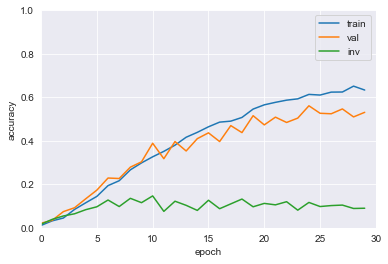

In [35]:
plt.plot(np.array(training_state['train_acc']), label='train')
plt.plot(np.array(training_state['val_acc']), label='val')
plt.plot(np.array(training_state['inv_acc']), label='inv')
plt.xlim(0, 30)
plt.ylim(0, 1)
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig(f'plots/{experiment_name}_acc.png')
plt.plot()

[]

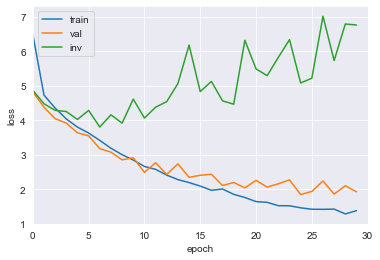

In [36]:
plt.plot(np.array(training_state['train_loss']), label='train')
plt.plot(np.array(training_state['val_loss']), label='val')
plt.plot(np.array(training_state['inv_loss']), label='inv')
plt.legend()
plt.xlim(0, 30)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(f'plots/{experiment_name}_loss.png')
plt.plot()

In [36]:
# TODO: Plot accuracy broken down by class in histogram, and show shots of poorly-classified celebrities.